In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Extended Kalman Filter
We start the process with initial parameters:
$$
m_0 = 1
$$
$$
P_0 = 0
$$

In [9]:
class RecursiveFiltering:

    def __init__(self, q, r, N, m_0, P_0):
        self.q = q
        self.r = r
        self.N = N
        self.P_0 = P_0
        self.m_0 = m_0
        
    def GenerateProcess(self):
        x = np.empty(self.N)
        x[0] = norm.rvs(self.m_0, np.sqrt(self.P_0))
        for k in range(1, self.N):
            x[k] = x[k - 1] - 0.01 * np.sin(x[k - 1]) + norm.rvs(0, np.sqrt(self.q))
        y = 0.5 * np.sin(2 * x) + norm.rvs(0, np.sqrt(self.r), self.N)
        return x, y

    def TaylorLinearization(self, y):
        x = np.empty(self.N)
        m = self.m_0
        P = self.P_0
        x[0] = norm.rvs(m, np.sqrt(P))
        for k in range(self.N):
            m_minus = m - 0.01 * np.sin(m)
            P_minus = P * (1 - 0.01 * np.cos(m)) ** 2 + self.q
            v = y[k] - 0.5 * np.sin(2 * m_minus)
            S = np.cos(2 * m_minus) ** 2 * P_minus + self.r
            K = np.cos(2 * m_minus) * P_minus / S
            m = m_minus + K * v
            P = P_minus - K ** 2 * S
            x[k] = norm.rvs(m, np.sqrt(P))
        return x
    
    def StatisticalLinearization(self, y):
        x = np.empty(self.N)
        m = self.m_0
        P = self.P_0
        x[0] = norm.rvs(m, np.sqrt(P))
        for k in range(1, self.N):
            m_minus = m - 0.01 * np.sin(m) * np.exp(-0.5 * P)
            P_minus = P * (1 - 0.01 * np.exp(-0.5 * P) * np.cos(m)) ** 2 + self.q
            v = y[k] - 0.5 * np.sin(2 * m_minus) * np.exp(-2 * P_minus)
            S = (np.cos(2 * m_minus) **2) * np.exp(-4 * P_minus) * P_minus + self.r
            K = np.cos(2 * m_minus) * np.exp(-2 * P_minus) * P_minus / S
            m = m_minus + K * v
            P = P_minus - K ** 2 * S
            x[k] = norm.rvs(m, np.sqrt(P))
        return x

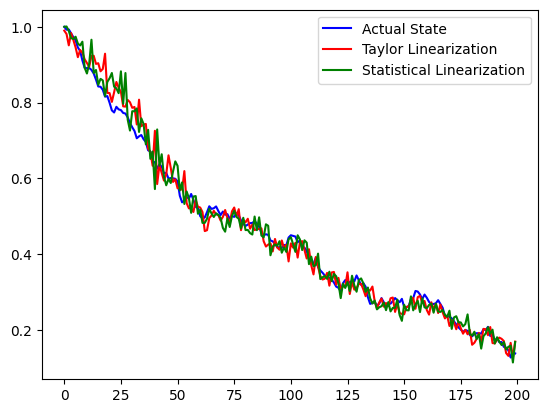

In [10]:
q = 0.0001
r = 0.0004
N = 200
m_0 = 1
P_0 = 0
filter = RecursiveFiltering(q, r, N, m_0, P_0)
x_1, y = filter.GenerateProcess()
x_2 = filter.TaylorLinearization(y)
x_3 = filter.StatisticalLinearization(y)
x = np.arange(N)
plt.plot(x, x_1, "b", label = "Actual State")
plt.plot(x, x_2, "r", label = "Taylor Linearization")
plt.plot(x, x_3, "g", label = "Statistical Linearization")
plt.legend()
plt.show()

# Grid Based Filter

In [11]:
class GridBasedFilter:
    def __init__(self, L, N):
        self.L = L
        self.N = N

    def RademacherSample():
        return np.random.choice([-1, 1])
    
    def UniformPDF(a, b, x):
        if a >= b or x < a or x > b:
            return 0
        return 1 / (b - a)

    def GenerateProcess(self):
        x = np.empty(self.N)
        x[0] = norm.rvs()
        for k in range(1, self.N):
            x[k] = x[k - 1] + self.L * GridBasedFilter.RademacherSample()
        y = (0.5 + np.random.uniform(0, 0.5, N)) * x
        return x, y
    
    def GridFilter(self, x_0, y):
        x = np.empty(self.N)
        x[0] = x_0
        w = np.zeros(2 * self.N)
        w[N] = 1
        possible_states = np.array([x_0 - self.N * self.L + i * self.L for i in range(2 * self.N)])
        pred_w = np.empty_like(w)
        for k in range(1, self.N):
            pred_w[0] = w[1] / 2
            pred_w[-1] = w[-2] / 2 
            for i in range(1, 2 * self.N - 1):
                pred_w[i] = (w[i - 1] + w[i + 1]) / 2
            for i in range(2 * self.N):
                a = min(possible_states[i] / 2, possible_states[i])
                b = max(possible_states[i] / 2, possible_states[i])
                w[i] = pred_w[i] * GridBasedFilter.UniformPDF(a, b, y[k])
            w /= np.sum(w)
            x[k] = np.random.choice(possible_states, p = w)
        return x

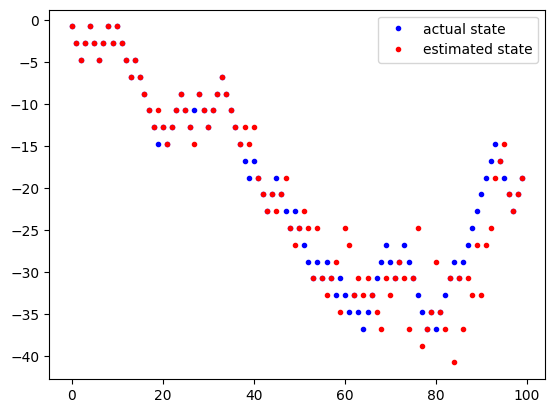

In [12]:
L = 2
N = 100
filter = GridBasedFilter(L, N)
actual_state, measurements = filter.GenerateProcess()
estimated_state = filter.GridFilter(actual_state[0], measurements)
plt.plot(np.arange(N), actual_state, ".b", label = "actual state")
plt.plot(np.arange(N), estimated_state, ".r", label = "estimated state")
plt.legend()
plt.show()

# Rejection Sampling and Monte Carlo Integration

In [13]:
def Rejection_Sample(f, g, g_dist, c):
    while True:
        x = g_dist()
        u = np.random.uniform(0, 1)
        if u <= f(x) / (c * g(x)):
            return x
        
def f(x):
    return 0.2 * norm.pdf(x, 1, 0.1) + 0.8 * norm.pdf(x, 2, 0.8)

def g(x):
    return norm.pdf(x, 0, 10)

In [14]:
N = 1000
samples = np.array([Rejection_Sample(f, g, lambda: norm.rvs(0, 10), 24.75) for i in range(N)])
samples = np.cos(samples) * (samples ** 2 - 3 * samples + 5)
print(np.sum(samples) / N)

-0.8264343562532807
